In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('macro_eco_data.csv')
df.rename(columns={
    'Crude Oil Price': 'Oil',
    'USD/INR': 'ER',
    'FIIs ($ Million)': 'FII'
}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

data = df[['Oil', 'ER', 'FII']].dropna()

data['Ln_Oil'] = np.log(data['Oil'])
data['Ln_ER']  = np.log(data['ER'])

system_df = data[['Ln_Oil', 'Ln_ER', 'FII']]

print("Data Prepared Successfully.")
print(system_df.head())


Data Prepared Successfully.
              Ln_Oil     Ln_ER          FII
Date                                       
2011-09-01  4.689419  3.889982 -3165.000000
2011-10-01  4.664476  3.884652 -1667.666667
2011-11-01  4.697020  3.955082  -170.333333
2011-12-01  4.674603  3.971235  1327.000000
2012-01-01  4.704744  3.902377  6975.333333


In [18]:
from scipy.stats import jarque_bera
desc_stats = pd.DataFrame(index=['Mean', 'Median', 'Max', 'Min', 'Std_Dev', 'Skewness', 'Kurtosis', 'JB_Stat', 'JB_PVal'])

for col in system_df.columns:
    series = system_df[col]
    jb_stat, jb_pval = jarque_bera(series)

    desc_stats[col] = [
        series.mean(), series.median(), series.max(), series.min(),
        series.std(), series.skew(), series.kurtosis(),
        jb_stat, jb_pval
    ]

print("\n--- Descriptive Statistics ---")
print(desc_stats.round(4))


--- Descriptive Statistics ---
           Ln_Oil   Ln_ER         FII
Mean       4.2631  4.2272   2332.9693
Median     4.2978  4.2273   3159.0000
Max        4.8171  4.4552  21156.0000
Min        2.9907  3.8847 -16674.0000
Std_Dev    0.3520  0.1412   7785.7146
Skewness  -0.6404 -0.3639     -0.2376
Kurtosis   0.1730 -0.4588     -0.3402
JB_Stat   11.0529  5.1052      2.4176
JB_PVal    0.0040  0.0779      0.2986


In [19]:
!pip install arch

In [20]:
from arch.unitroot import ADF, PhillipsPerron

def run_unit_root(data, variable_name):
    print(f"\nResults for {variable_name}:")

    # 1. Level Data
    adf_level = ADF(data)
    pp_level  = PhillipsPerron(data)
    print(f"  Level - ADF t-stat: {adf_level.stat:.4f} (p={adf_level.pvalue:.4f})")
    print(f"  Level - PP  t-stat: {pp_level.stat:.4f}  (p={pp_level.pvalue:.4f})")

    # 2. First Difference
    diff_data = data.diff().dropna()
    adf_diff = ADF(diff_data)
    pp_diff  = PhillipsPerron(diff_data)
    print(f"  Diff  - ADF t-stat: {adf_diff.stat:.4f} (p={adf_diff.pvalue:.4f})")
    print(f"  Diff  - PP  t-stat: {pp_diff.stat:.4f}  (p={pp_diff.pvalue:.4f})")

print("\n--- Unit Root Tests (ADF & PP) ---")
for col in system_df.columns:
    run_unit_root(system_df[col], col)


--- Unit Root Tests (ADF & PP) ---

Results for Ln_Oil:
  Level - ADF t-stat: -2.2564 (p=0.1864)
  Level - PP  t-stat: -2.2196  (p=0.1992)
  Diff  - ADF t-stat: -9.6027 (p=0.0000)
  Diff  - PP  t-stat: -9.0360  (p=0.0000)

Results for Ln_ER:
  Level - ADF t-stat: -1.7865 (p=0.3872)
  Level - PP  t-stat: -1.9137  (p=0.3256)
  Diff  - ADF t-stat: -13.0456 (p=0.0000)
  Diff  - PP  t-stat: -13.9410  (p=0.0000)

Results for FII:
  Level - ADF t-stat: -4.4386 (p=0.0003)
  Level - PP  t-stat: -3.3569  (p=0.0125)
  Diff  - ADF t-stat: -4.7411 (p=0.0001)
  Diff  - PP  t-stat: -6.5013  (p=0.0000)


In [21]:
from statsmodels.tsa.api import VAR

model_var = VAR(system_df)
lag_order = model_var.select_order(maxlags=12)

print("\n--- Optimal Lag Length Criteria ---")
print(lag_order.summary())

optimal_lag = lag_order.aic
print(f"Selected Optimal Lag: {optimal_lag}")


--- Optimal Lag Length Criteria ---
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        11.56       11.62   1.045e+05       11.58
1        4.232       4.472       68.84       4.329
2        3.679      4.099*       39.62       3.850
3        3.634       4.233       37.88       3.877
4        3.542       4.321       34.57       3.858
5        3.385       4.344       29.59      3.775*
6        3.450       4.589       31.63       3.913
7        3.496       4.815       33.19       4.032
8       3.282*       4.780      26.87*       3.891
9        3.355       5.033       29.02       4.037
10       3.371       5.230       29.64       4.126
11       3.380       5.419       30.09       4.208
12       3.402       5.620       30.96       4.303
--------------------------------------------------
Selected Optimal Lag: 8


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [22]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johansen_test = coint_johansen(system_df, det_order=0, k_ar_diff=optimal_lag)

print("\n--- Johansen Cointegration Test Results ---")
print("Trace Statistic vs Critical Values (90%, 95%, 99%)")
for i in range(len(johansen_test.lr1)):
    print(f"r <= {i}: Stat = {johansen_test.lr1[i]:.4f} | CV(95%) = {johansen_test.cvt[i, 1]:.4f}")

print("\nMax-Eigen Statistic vs Critical Values (90%, 95%, 99%)")
for i in range(len(johansen_test.lr2)):
    print(f"r <= {i}: Stat = {johansen_test.lr2[i]:.4f} | CV(95%) = {johansen_test.cvm[i, 1]:.4f}")


--- Johansen Cointegration Test Results ---
Trace Statistic vs Critical Values (90%, 95%, 99%)
r <= 0: Stat = 34.2997 | CV(95%) = 29.7961
r <= 1: Stat = 6.4900 | CV(95%) = 15.4943
r <= 2: Stat = 0.3322 | CV(95%) = 3.8415

Max-Eigen Statistic vs Critical Values (90%, 95%, 99%)
r <= 0: Stat = 27.8097 | CV(95%) = 21.1314
r <= 1: Stat = 6.1579 | CV(95%) = 14.2639
r <= 2: Stat = 0.3322 | CV(95%) = 3.8415


In [23]:
from statsmodels.tsa.vector_ar.vecm import VECM
cointegration_rank = 1

vecm_model = VECM(system_df, k_ar_diff=optimal_lag, coint_rank=cointegration_rank, deterministic="ci")
vecm_res = vecm_model.fit()

print("\n--- VECM Model Summary ---")
print(vecm_res.summary())

print("\nLong-Run Cointegration Vector (Beta):")
print(vecm_res.beta)


--- VECM Model Summary ---
Det. terms outside the coint. relation & lagged endog. parameters for equation Ln_Oil
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Ln_Oil      0.3338      0.082      4.083      0.000       0.174       0.494
L1.Ln_ER      -0.7300      0.457     -1.596      0.111      -1.627       0.167
L1.FII      4.244e-06   3.35e-06      1.268      0.205   -2.32e-06    1.08e-05
L2.Ln_Oil     -0.2286      0.086     -2.656      0.008      -0.397      -0.060
L2.Ln_ER       0.2317      0.462      0.501      0.616      -0.675       1.138
L2.FII     -4.759e-06    4.6e-06     -1.035      0.300   -1.38e-05    4.25e-06
L3.Ln_Oil     -0.0461      0.089     -0.518      0.604      -0.220       0.128
L3.Ln_ER      -0.1973      0.458     -0.431      0.666      -1.094       0.700
L3.FII       2.02e-06   3.75e-06      0.539      0.590   -5.33e-06    9.37e-06
L4.Ln_Oil     -0.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
print("\n--- Granger Causality (Wald Test) ---")
granger_results = vecm_res.test_granger_causality(caused="FII", signif=0.05)
print("Dependent Variable: FII")
print(granger_results.summary())

granger_results_er = vecm_res.test_granger_causality(caused="Ln_ER", signif=0.05)
print("\nDependent Variable: Ln_ER")
print(granger_results_er.summary())

granger_results_oil = vecm_res.test_granger_causality(caused="Ln_Oil", signif=0.05)
print("\nDependent Variable: Ln_Oil")
print(granger_results_oil.summary())


--- Granger Causality (Wald Test) ---
Dependent Variable: FII
Granger causality F-test. H_0: ['Ln_Oil', 'Ln_ER'] do not Granger-cause FII. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value               df             
-------------------------------------------------------------------
         1.652          1.632   0.046 (np.int64(18), np.int64(366))
-------------------------------------------------------------------

Dependent Variable: Ln_ER
Granger causality F-test. H_0: ['Ln_Oil', 'FII'] do not Granger-cause Ln_ER. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value               df             
-------------------------------------------------------------------
         1.281          1.632   0.196 (np.int64(18), np.int64(366))
-------------------------------------------------------------------

Dependent Variable: Ln_Oil
Granger causality F-test. H_0: ['Ln_ER', 'FII'] do not Granger-cause Ln_Oil. C

<Figure size 1000x800 with 0 Axes>

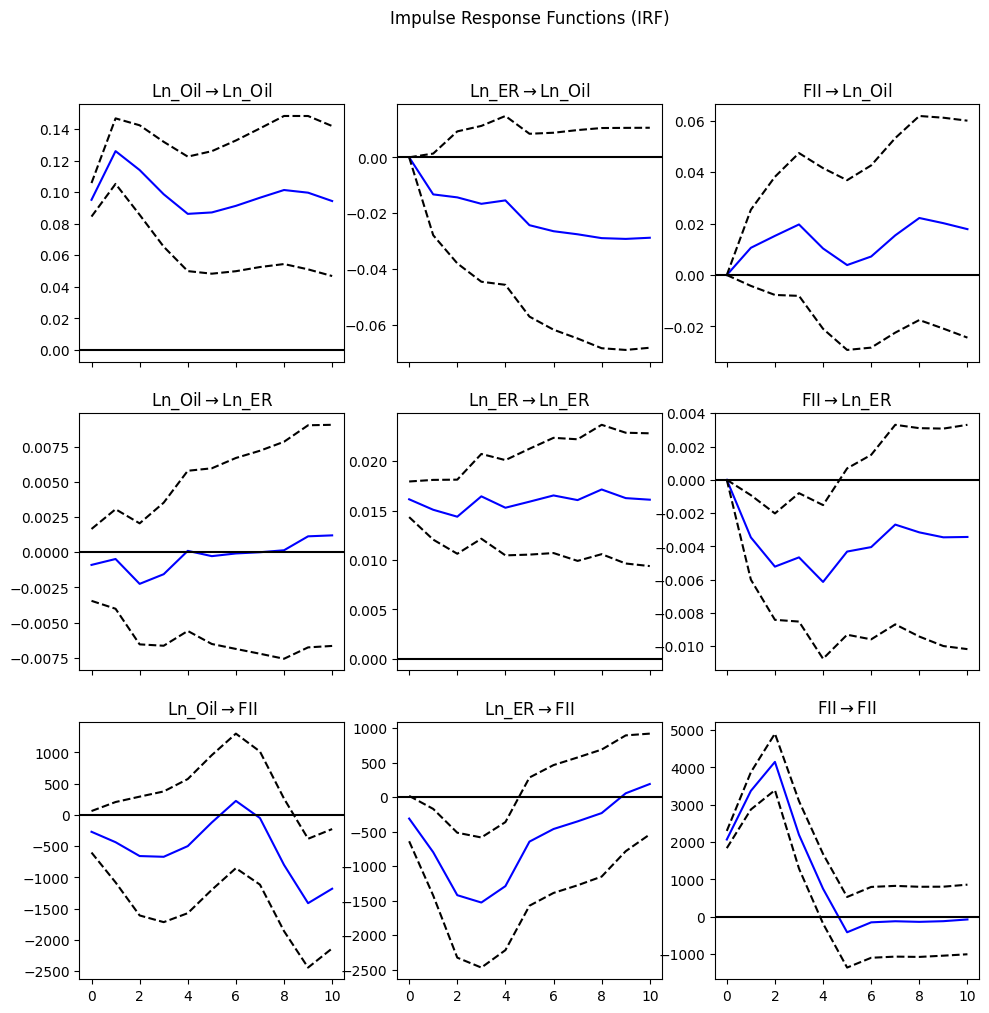

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.33208745e+00 -7.22577471e-01  5.11639367e-06]
  [-1.29002533e-03  9.02087441e-01 -1.67221676e-06]
  [-1.25375051e+02 -1.80627299e+04  1.62963206e+00]]

 [[ 1.21235553e+00 -7.45101033e-01  7.35888080e-06]
  [-2.28456822e-02  8.42217591e-01 -2.52091905e-06]
  [-1.67938936e+03 -4.94037757e+04  2.00473089e+00]]

 [[ 1.05611933e+00 -8.46352312e-01  9.50335100e-06]
  [-1.36036627e-02  9.75073981e-01 -2.25192425e-06]
  [-4.73439778e+03 -7.42090359e+04  1.06103599e+00]]

 [[ 9.12519073e-01 -8.57803872e-01  4.99067788e-06]
  [ 9.71170637e-04  8.89866459e-01 -2.96495421e-06]
  [-4.92003275e+03 -7.29512652e+04  3.63007658e-01]]

 [[ 9.07377714e-01 -1.46719054e+00  1.87435763e-06]
  [ 6.77642031e-05  9.44858687e-01 -2.08330433e-06]
  [-2.27310987e+03 -4.38364435e+04 -2.00001941e-01]]

 [[ 9.54862337e-01 -1.56943190e+00  3.48272976e-06]


In [25]:
irf = vecm_res.irf(periods=10)

plt.figure(figsize=(10,8))
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (IRF)', y=1.02)
plt.show()
print(irf.irfs)

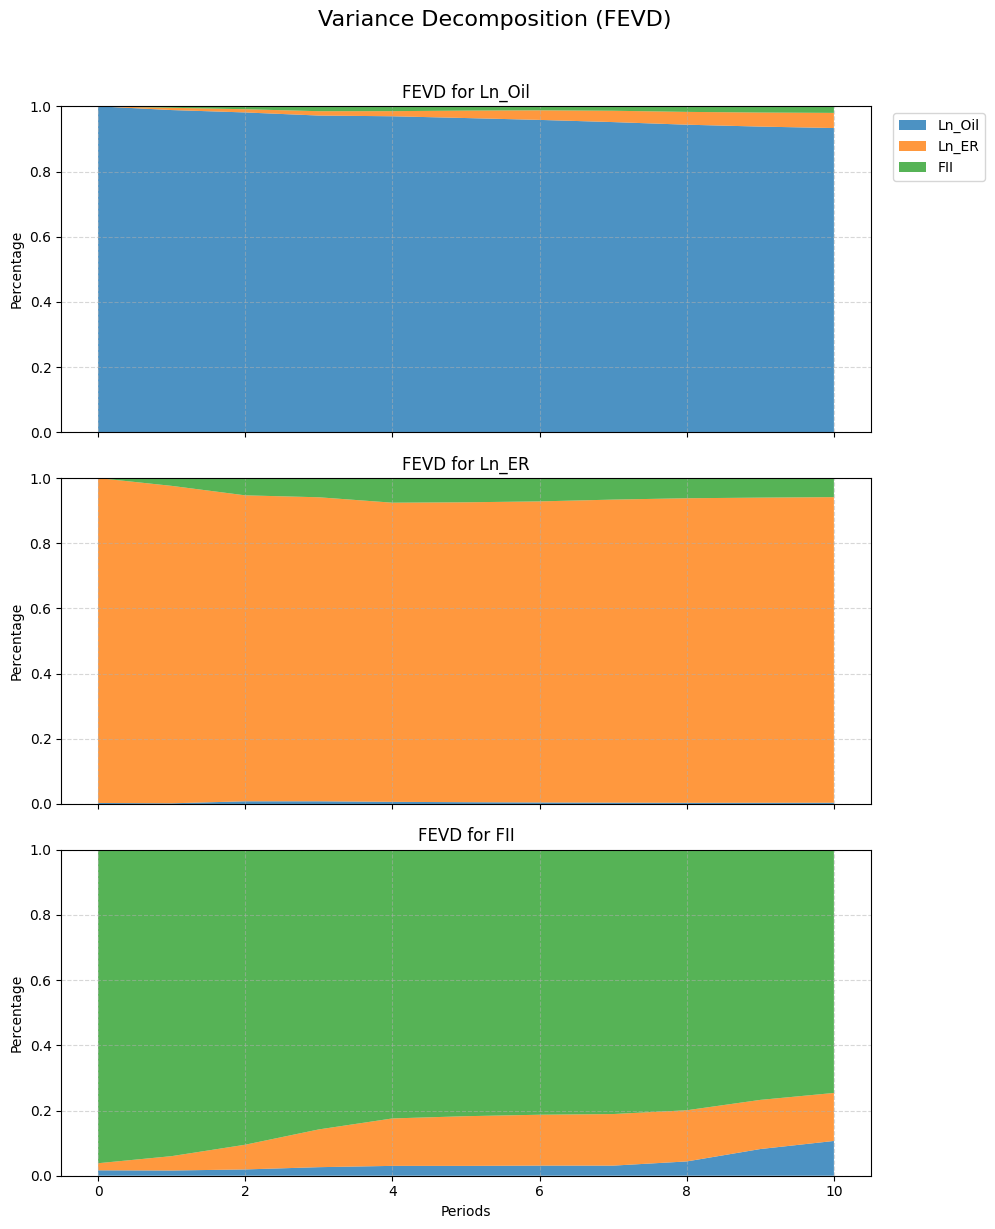


--- Variance Decomposition (Period 10) ---
Variable   | Ln_Oil     | Ln_ER      | FII       
--------------------------------------------------
Ln_Oil     | 0.9334 | 0.0465 | 0.0201
Ln_ER      | 0.0038 | 0.9377 | 0.0585
FII        | 0.1067 | 0.1473 | 0.7460


In [26]:
import matplotlib.pyplot as plt
import numpy as np
periods = 10
irf_obj = vecm_res.irf(periods=periods)
orth_irfs = irf_obj.orth_irfs
sq_irfs = orth_irfs ** 2
cum_sq = np.cumsum(sq_irfs, axis=0)

total_var = np.sum(cum_sq, axis=2, keepdims=True)

fevd_data = cum_sq / total_var

variables = system_df.columns
n_vars = len(variables)
fig, axes = plt.subplots(nrows=n_vars, ncols=1, figsize=(10, 12), sharex=True)

time_steps = range(periods + 1)

for i, var_name in enumerate(variables):
    ax = axes[i]
    data_to_plot = fevd_data[:, i, :]

    ax.stackplot(time_steps, data_to_plot.T, labels=variables, alpha=0.8)

    ax.set_title(f'FEVD for {var_name}')
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.5)

    if i == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.xlabel('Periods')
plt.suptitle('Variance Decomposition (FEVD)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
print("\n--- Variance Decomposition (Period 10) ---")
print(f"{'Variable':<10} | " + " | ".join([f"{v:<10}" for v in variables]))
print("-" * 50)

for i, var_name in enumerate(variables):
    values = fevd_data[-1, i, :]
    values_str = " | ".join([f"{v:.4f}" for v in values])
    print(f"{var_name:<10} | {values_str}")

In [27]:
from statsmodels.stats.stattools import durbin_watson

print("\n--- Residual Diagnostics ---")
normality = vecm_res.test_normality()
print("Normality Test (Jarque-Bera):")
print(normality.summary())
out = durbin_watson(vecm_res.resid)
for col, val in zip(system_df.columns, out):
    print(f"Durbin-Watson ({col}): {val:.4f}")


--- Residual Diagnostics ---
Normality Test (Jarque-Bera):
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         210.4          12.59   0.000  6
----------------------------------------
Durbin-Watson (Ln_Oil): 1.9906
Durbin-Watson (Ln_ER): 1.9385
Durbin-Watson (FII): 1.9650
